# Proyecto vision por computadora - Control de Dispositivos IoT Basado en Reconocimiento de Gestos con Manos

## Integrantes
- Agustin Ovando
- Eduardo Gomez
- Juan de Dios Larrea

In [1]:
#Librerias
import cv2
import mediapipe as mp
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import joblib
import numpy as np
import magichue
import cv2
import random

In [2]:
# Inicializar MediaPipe Hands
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

# Función para extraer puntos clave de la mano
def extract_keypoints(frame):
    results = hands.process(frame)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.append([lm.x, lm.y, lm.z])
            return keypoints
    return None


In [10]:
# Tipos de gestos
gestures = ['apagar', 'encender', 'subirIntensidad', 'bajarIntensidad', 'colorRojo', 'colorRandom']

# Captura de video para entrenar modelo
cap = cv2.VideoCapture(0)
with open('keypoints.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for gesture in gestures:
        print(f"Collecting data for {gesture}")
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            keypoints = extract_keypoints(frame)
            

            if keypoints:
                row = [gesture]
                for point in keypoints:
                    row.extend(point)
                writer.writerow(row)

            cv2.imshow('Frame', frame)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

cap.release()
cv2.destroyAllWindows()

Accuracy: 0.9197860962566845


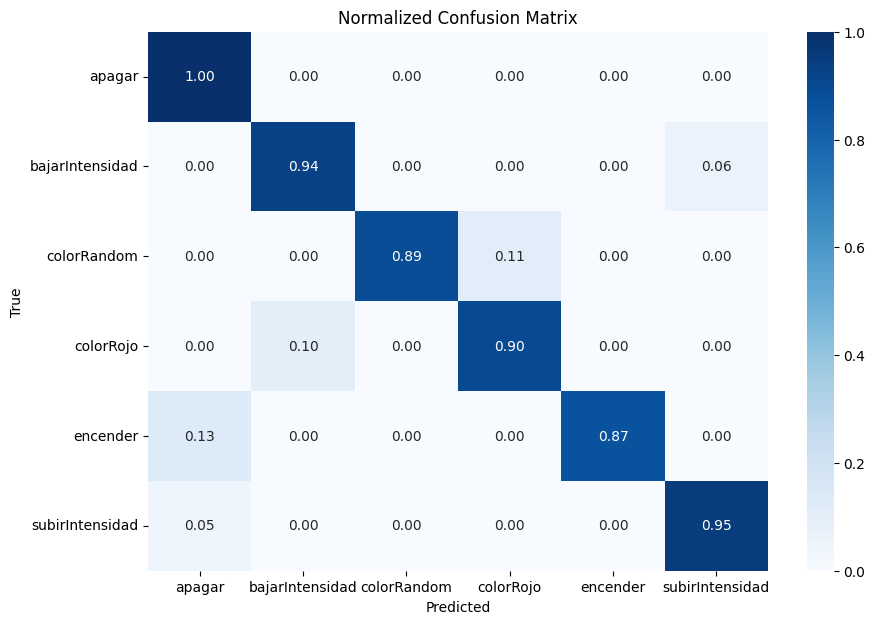

['label_encoder.pkl']

In [3]:
# Cargar los datos
data = pd.read_csv('keypoints.csv', header=None)

# Separar características y etiquetas
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# Codificar las etiquetas
le = LabelEncoder()
y = le.fit_transform(y)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir y entrenar el modelo
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
mlp.fit(X_train, y_train)

# Evaluar el modelo
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Crear matriz de confusión normalizada
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Visualizar la matriz de confusión normalizada
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Guardar el modelo
joblib.dump(mlp, 'hand_gesture_model.pkl')
joblib.dump(le, 'label_encoder.pkl')



In [21]:
warnings.filterwarnings("ignore")

# Ajustar la dirección IP de la ampolleta
bulb_ip = '192.168.86.26'
print(f'Conectando a la ampolleta en {bulb_ip}')

# Variable conectada a la ampolleta
light = magichue.LocalLight(bulb_ip)

# Activar funcionalidad RGB
if light.is_white:
    light.is_white = False

# Cargar el modelo y el codificador de etiquetas
mlp = joblib.load('hand_gesture_model.pkl')
le = joblib.load('label_encoder.pkl')

# Umbral de probabilidad
threshold = 0.95

# Captura de video para predicciones en tiempo real
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    #frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    keypoints = extract_keypoints(frame)

    if keypoints:
        keypoints = np.array(keypoints).flatten().reshape(1, -1)
        probabilities = mlp.predict_proba(keypoints)
        max_prob = np.max(probabilities)
        if max_prob > threshold:
            prediction = mlp.predict(keypoints)
            gesture = le.inverse_transform(prediction)[0]

            if gesture == 'apagar':
                light.turn_off()
                print('Apagar')
            elif gesture == 'encender':    
                if not light.on:
                    light.turn_on()
                    light.rgb = (255, 255, 0)
                    print('Encender')
            elif gesture == 'subirIntensidad':
                intensidadActual = light.brightness
                if intensidadActual < 255:
                    light.brightness += 5
                print('subirIntensidad')
            elif gesture == 'bajarIntensidad':
                intensidadActual = light.brightness
                if intensidadActual > 0:
                    light.brightness -= 5
                print('bajarIntensidad')
            elif gesture == 'colorRojo':
                light.rgb = (255, 0, 0)
                print('colorRojo')
            elif gesture == 'colorRandom':
                light.rgb = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                print('colorRandom')

            cv2.putText(frame, f"{gesture}: {max_prob:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Frame', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Conectando a la ampolleta en 192.168.86.26
